# Rossmo's Formula (Standard)
The standard formula returns the probability $p_{i,j}$ of a given sector $S_{i,j}$. The coordinates $i$ and $j$ are that of a particular row and column (respectively) of a given raster image:

$$p_{i,j} = k\sum_{n=1}^{T} \left[ \frac{\phi_{ij}}{(|X_i-x_n|+|Y_j-y_n|)^f} + \frac{(1-\phi_{ij})(B^{g-f})}{(2B-|X_i-x_n|-|Y_j-y_n|)^g} \right],$$
$$\text{where:}\phi_{ij}=\begin{cases}1, & \text{if} & (|X_i-x_n|+|Y_j-y_n|) \gt B\\0, & \text{else}\end{cases}$$

Where:
- $(x_n, y_n), n=1,...,T$ are the coordinates of $T$ number of past crimes.
- $\phi_{ij}$ is an indicator function that returns $0$ if $(X_i,Y_j) \in B$ and $1$ if the point is outside the buffer zone $B$.
- $k \gt 0$ is a normalization constant to ensure that $\sum_{i}\sum_{j}p_{i,j} \le 1$.
- $B$ is the buffer zone radius constant.
- $f$ and $g$ are variables chosen to best fit the data.

# The Vector Version
The way I would like to understand this is; a 2D raster image is analogous to that of a 2D-Euclidean space, since the model is based on Euclidean coordinate system. Therefore, a given sector $S_{i,j}$ is simply a 2D vector $\vec{s}$ within our 2D space $\vec{S}$. As such, the entity $p_{i,j}$ can be thought of as a probability function $P(\vec{s})$ that takes any given point $\vec{s} \in \vec{S}$ and gives the probability of that vector. The coordinates of the crime $(x_n, y_n)$ can be thought to be an element of a finite set of vectors $\vec{C}$ denoted by $\vec{r}$. And finally, the indicator function $\phi_{i,j}$ in this case, $\phi(\vec{s}, \vec{r})$, will output a constant, $1$ or $0$, based on the current position of operation within our space $\vec{S}$. Hence, we can (somewhat) loosely re-model the formula as follows:

$$P(\vec{s}) = k\sum_{\vec{r} \in \vec{C}} \left[ \frac{\phi(\vec{s}, \vec{r})}{(|\vec{s}-\vec{r}|)^f} + \frac{[1-\phi(\vec{s}, \vec{r})](B^{g-f})}{(2B-|\vec{s}-\vec{r}|)^g} \right],$$
$$\text{where:}\phi(\vec{s}, \vec{r})=\begin{cases}1, & \text{if} & |\vec{s}-\vec{r}| \gt B\\0, & \text{else}\end{cases}$$

Where the following hold:
- $\vec{S},\vec{C} \in \R_{\ge 0}^{2}$
- $\vec{r} \in \vec{C}$
- $\vec{s} \in \vec{S}$
- $k \gt 0$ is a normalization constant to ensure that $P(\vec{s}) \le 1$.
- $B$ is the buffer zone radius constant.
- $f$ and $g$ are variables chosen to best fit the data.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch

# getting device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# making sure gpu can be used
print(device)

# max sector bound
N = 100

# creating sector
S = np.meshgrid(np.linspace(0, N, N+1), np.linspace(0, N, N+1))


cuda


## Simple functional model (Rough model)
Creating necessary functions and initializing the constants

/tmp/ipykernel_11692/3225359345.py:27: RuntimeWarning: invalid value encountered in scalar divide
  second_term = ((1-phi(s, r))*np.float_power(B,(g-f)))/(np.float_power(2*B - np.linalg.norm(s-r), g))
/tmp/ipykernel_11692/3225359345.py:26: RuntimeWarning: invalid value encountered in scalar divide
  first_term = phi(s, r)/np.float_power(np.linalg.norm(s-r),f)


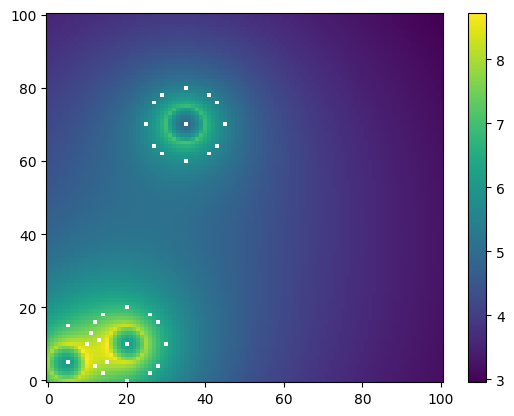

In [3]:
# initializing constants
B = 5.0
f = 0.5
g = 1.0
k = 10.0

# indicator function
def phi(s, r):
    # d = np.abs(s - r)
    # if d > B:
    if np.linalg.norm(s - r) > B:
        return 1.0
    else:
        return 0.0
    
# probability function
def P(S, C):
    Sv = np.stack(S, axis=2)
    Pv = []
    for _ in Sv:
        p = 0.0
        row = []
        for s in _:
            prob_sum = 0.0
            for r in C:
                first_term = phi(s, r)/np.float_power(np.linalg.norm(s-r),f)
                second_term = ((1-phi(s, r))*np.float_power(B,(g-f)))/(np.float_power(2*B - np.linalg.norm(s-r), g))

                prob_sum += first_term + second_term

            p = k*prob_sum
            row.append(p)
        Pv.append(row)

    return Pv

# setting coordinates for crime locations
r1 = np.array([5, 5])
r2 = np.array([20, 10])
r3 = np.array([35, 70])

C = [r1, r2, r3]

# calculating the probablity over the vector space
Z = P(S, C)

# plotting the heatmap
xv, yv = S

plt.pcolormesh(xv, yv, Z)
plt.colorbar()

## Converting to a class
It's better to create a class of "the problem" during simulation. It comes in handy when we would like to run multiple experiments.

In [4]:
class Rossmo:
    def __init__(self, C):
        self.C = C

    # indicator function
    def phi(self, d, B) -> float:
        if d > B:
            return 1.0
        else:
            return 0.0
    
    # probability function
    def simulate(self, S, B, f, g, k, algo="man") -> None:
        Sv = np.stack(S, axis=2)
        Pv = []
        epsilon = 0.01
        for _ in Sv:
            p = 0.0
            row = []
            for s in _:
                prob_sum = 0.0
                for r in self.C:

                    match algo:
                    
                        case "man":
                            # manhattan distance
                            d = abs(s[0] - r[0]) + abs(s[1] - r[1])

                        case "norm":
                            # distance as a vector norm
                            d = np.linalg.norm(s-r)

                        case _:
                            raise ValueError("distance type not supported")

                    num_1 = self.phi(d, B)
                    den_1 = (np.sign(d) * (np.abs(d)) ** f) + epsilon

                    num_2 = (1-self.phi(d, B))*(B**(g-f))
                    temp = (2*B - d + epsilon)
                    den_2 = np.sign(temp) * (np.abs(temp)) ** g

                    first_term = np.divide(num_1, den_1)
                    second_term = np.divide(num_2, den_2)

                    prob_sum += first_term + second_term

                p = k*prob_sum
                row.append(p)
            Pv.append(row)

        xv, yv = S

        fig, ax = plt.subplots()

        c = ax.pcolormesh(xv, yv, Pv, cmap="coolwarm")
        fig.colorbar(c, ax=ax)

        plt.scatter(*zip(*self.C), color="#ff0000", marker="*")


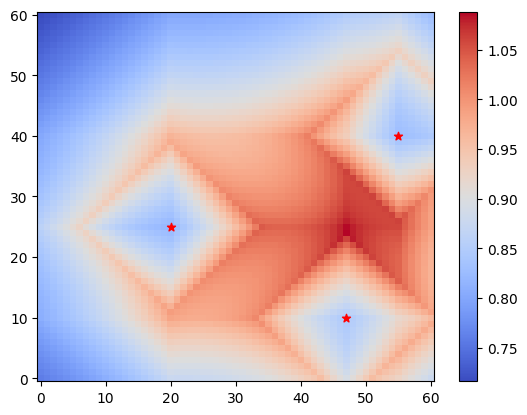

In [6]:
# city map space
city_bound = 60

# # integer range
# cb_x = np.arange(0, city_bound+1, 1)
# cb_y = np.arange(0, city_bound+1, 1)

# real range
cb_x = np.linspace(0, city_bound, city_bound+1)
cb_y = np.linspace(0, city_bound, city_bound+1)

City = np.meshgrid(cb_x, cb_y)

criminal_1 = [(20,25), (47,10), (55,40)]

case_1 = Rossmo(criminal_1)
case_1.simulate(S=City, B=14, f=1/3, g=2/3, k=1.0, algo="man")

## Optimizing our algorithm
The above algorithm is rudimentary and very readable. It helps us understand how the steps work. However, we can optimize our code to leverage built-in functions of NumPy. Note that NumPy runs on the CPU, hence it's CPU intensive. For our purposes, we will call it RossmoCPU to distinguish it from the previous class.

In [7]:
class RossmoCPU:
    def __init__(self, C):
        # Convert C to a NumPy array
        self.C = np.array(C, dtype=np.float32)

    def phi(self, d, B):
        return np.where(d > B, 1.0, 0.0)

    def simulate(self, S, B, f, g, k, algo="man"):
        B = np.array(B, dtype=np.float32)
        epsilon = np.array(0.01, dtype=np.float32)

        # S is our 2D vector space
        grid_x, grid_y = S
        height, width = grid_x.shape
        
        # Generating pairwise coordinates
        S_reshaped = np.stack([grid_x.ravel(), grid_y.ravel()], axis=1)

        if algo == "man":
            # Calculate Manhattan distance
            d = np.sum(np.abs(S_reshaped[:, np.newaxis, :] - self.C[np.newaxis, :, :]), axis=2)
        elif algo == "norm":
            # Calculate Euclidean distance
            d = np.linalg.norm(S_reshaped[:, np.newaxis, :] - self.C[np.newaxis, :, :], axis=2)
        else:
            raise ValueError("distance type not supported")

        # Calculate probabilities
        num_1 = self.phi(d, B)
        den_1 = np.sign(d) * (np.abs(d) ** f) + epsilon

        num_2 = (1 - self.phi(d, B)) * (B ** (g - f))
        temp = (2 * B - d + epsilon)
        den_2 = np.sign(temp) * (np.abs(temp) ** g)

        first_term = num_1 / den_1
        second_term = num_2 / den_2

        prob_sum = k * (first_term + second_term)

        # Sum probabilities across all C for each point in S
        Pv_grid = np.sum(prob_sum, axis=1)

        # Reshape back to the original grid shape
        Pv = Pv_grid.reshape(height, width)

        fig, ax = plt.subplots()
        c = ax.pcolormesh(grid_x, grid_y, Pv, cmap="coolwarm")
        fig.suptitle("Rossmo run on CPU")
        fig.colorbar(c, ax=ax)
        plt.scatter(*zip(*self.C), color="#ff0000", marker="*")

## Running simulation on the GPU using PyTorch
Sometimes we need to compute a lot of values, especially floats. In most cases, simulations tend to be higher dimensional i.e. with many variables. A good example of this is the topic of **Multivariable Calculus**, where we often deal with 2 to 3 variables, sometimes more! In such cases, it's quite helpful to leverage the most out of your hardware, such as a network of cluster computers or an array of GPUs. As for personal cases, sometimes we may have dedicated GPUs on our systems. If so, we can try and utilize the power of our GPUs. For our purposes, we will call this class RossmoGPU to distinguish it from its CPU counterpart.

In [8]:
class RossmoGPU:
    def __init__(self, C):
        self.C = torch.tensor(C, dtype=torch.float32, device=device)

    def phi(self, d, B):
        return (d > B).float()

    def simulate(self, S, B, f, g, k, algo="man"):
        B = torch.tensor(B, dtype=torch.float32, device=self.C.device)
        epsilon = torch.tensor(0.01, dtype=torch.float32, device=self.C.device)

        # S is a tuple of grid tensors
        grid_x, grid_y = S
        height, width = grid_x.shape

        # Generate a flattened grid of coordinates
        S_reshaped = torch.stack([grid_x.reshape(-1), grid_y.reshape(-1)], dim=1).to(device)

        # Calculate distances
        if algo == "man":
            # Expand dims for broadcasting: [height*width, 1, 2] and [1, num_crimes, 2]
            d = torch.abs(S_reshaped.unsqueeze(1) - self.C.unsqueeze(0)).sum(-1)
        elif algo == "norm":
            d = torch.norm(S_reshaped.unsqueeze(1) - self.C.unsqueeze(0), dim=2)
        else:
            raise ValueError("distance type not supported")

        # Calculate probabilities
        num_1 = self.phi(d, B)
        den_1 = torch.sign(d) * torch.pow(torch.abs(d), f) + epsilon

        num_2 = (1 - self.phi(d, B)) * (B ** (g - f))
        temp = (2 * B - d + epsilon)
        den_2 = torch.sign(temp) * torch.pow(torch.abs(temp), g)

        first_term = num_1 / den_1
        second_term = num_2 / den_2

        # Normalize the probabilities
        prob_sum = k * (first_term + second_term)

        # Sum probabilities across all C for each point in S
        Pv_grid = prob_sum.sum(dim=1)

        # Plot the heatmap
        Pv = Pv_grid.reshape(height, width).cpu().data.numpy()
        xv = [x.cpu().data.numpy() for x in grid_x]
        yv = [y.cpu().data.numpy() for y in grid_y]

        fig, ax = plt.subplots()
        c = ax.pcolormesh(xv, yv, Pv, cmap="coolwarm")
        fig.suptitle("Rossmo run on GPU")
        fig.colorbar(c, ax=ax)

        Cv = [c.cpu().data.numpy() for c in self.C]
        plt.scatter(*zip(*Cv), color="#ff0000", marker="*")

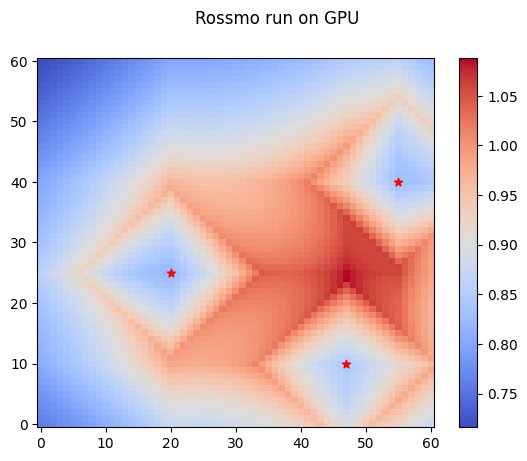

In [9]:
# city map space
city_bound = 60

# real range
cb_x = torch.linspace(0, city_bound, city_bound+1).to(device)
cb_y = torch.linspace(0, city_bound, city_bound+1).to(device)

City = torch.meshgrid(cb_x, cb_y, indexing="ij")

criminal_1 = [(20,25), (47,10), (55,40)]

case_1 = RossmoGPU(criminal_1)
case_1.simulate(S=City, B=14, f=1/3, g=2/3, k=1.0, algo="man")

## Comparison
Comparing the performance on CPU and GPU

In [12]:
# bound
N = 100

# divisions
dN = 1001

# real range cpu
x_cpu = np.linspace(0, N, dN)
y_cpu = np.linspace(0, N, dN)

# real range gpu
x_gpu = torch.linspace(0, N, dN).to(device)
y_gpu = torch.linspace(0, N, dN).to(device)

# cpu meshrid
S_cpu = np.meshgrid(x_cpu, y_cpu, indexing="ij")

# gpu meshgrid
S_gpu = torch.meshgrid(x_gpu, y_gpu, indexing="ij")

# crimes
crimes = [(20,25), (47,10), (55,40)]

# parameters
B = 14
f = 1/3
g = 2/3
k = 1.0
algo = "norm"

# setting criminals
criminal_cpu = RossmoCPU(crimes)
criminal_gpu = RossmoGPU(crimes)

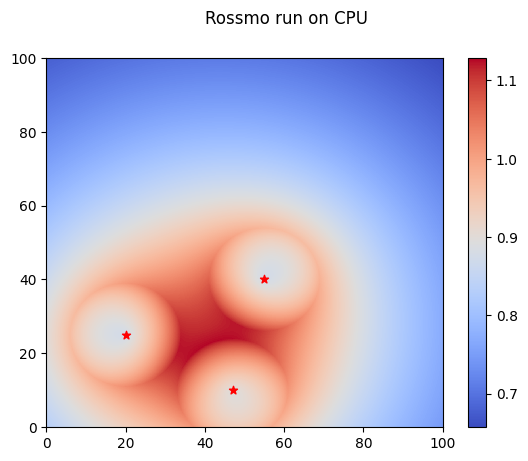

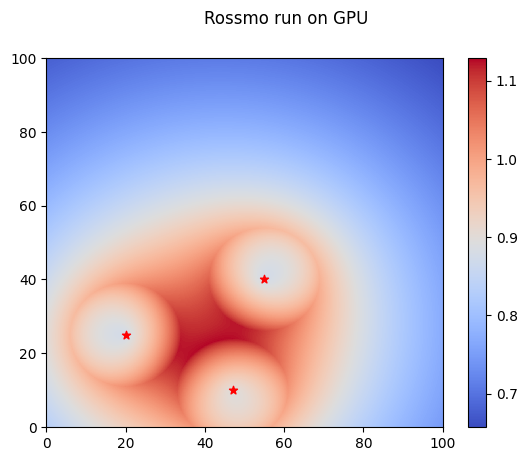

In [13]:
criminal_cpu.simulate(S_cpu, B, f, g, k, algo)
criminal_gpu.simulate(S_gpu, B, f, g, k, algo)

## Comparison 2
Trying to test the limit of CPU vs GPU computation

In [14]:
import random

# bound
N = 100

# divisions
dN = 1001

# real range cpu
x_cpu = np.linspace(0, N, dN)
y_cpu = np.linspace(0, N, dN)

# real range gpu
x_gpu = torch.linspace(0, N, dN).to(device)
y_gpu = torch.linspace(0, N, dN).to(device)

# cpu meshrid
S_cpu = np.meshgrid(x_cpu, y_cpu, indexing="ij")

# gpu meshgrid
S_gpu = torch.meshgrid(x_gpu, y_gpu, indexing="ij")

# crimes
# random.seed(123456789)
n_crimes = 30

crimes = []

for c in range(n_crimes):
    point = [random.randint(0, 100), random.randint(0, 100)]
    crimes.append(point)

# parameters
B = 10
f = 1/3
g = 2/3
k = 1.0
algo = "man"

args = (B, f, g, k, algo)

# print the crimes
# print(crimes)

# setting criminals
criminal_cpu = RossmoCPU(crimes)
criminal_gpu = RossmoGPU(crimes)

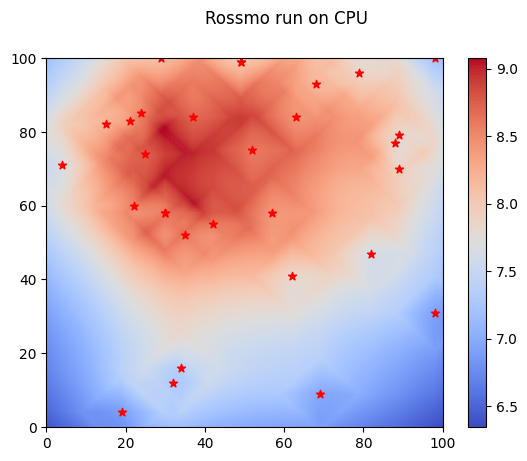

In [15]:
criminal_cpu.simulate(S_cpu, *args)

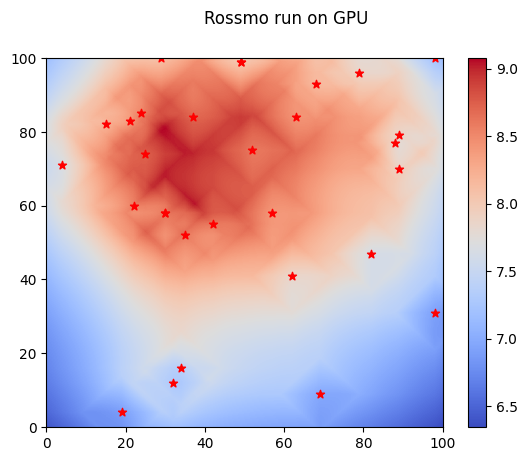

In [16]:
criminal_gpu.simulate(S_gpu, *args)